In [1]:
import os
import lib
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input, Conv2D,Flatten
from tensorflow.keras.backend import clear_session

from importlib import reload
reload(lib)

import warnings
warnings.filterwarnings('ignore')

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Multimodal arquitecture


In [3]:
data_dir = "/home/daielchom/Documents/projects/maestria/data/datasets/leaf_classification/"

In [4]:
split=0.7

In [5]:
X_train_f, _, X_train_ri, y_train, X_test_f, _, X_test_ri, y_test, species, num_classes, _, _ = lib.get_splitted_data(data_dir=data_dir, check_id_sets=True, verbose=1, use_resize_images=True, split=split)

The intersection between train and test set is 0
There are 99 classes for the classification task.


#### target onehot

In [6]:
y_train_oh = np.eye(num_classes)[y_train]
y_test_oh  = np.eye(num_classes)[y_test]

In [7]:
X_train_ri = X_train_ri.reshape((X_train_ri.shape[0], X_train_ri.shape[1], X_train_ri.shape[2], 1))
X_test_ri = X_test_ri.reshape((X_test_ri.shape[0], X_test_ri.shape[1], X_test_ri.shape[2], 1))

In [8]:
X_train_f.shape, X_train_ri.shape, y_train_oh.shape

((693, 194), (693, 128, 128, 1), (693, 99))

In [9]:
X_test_f.shape, X_test_ri.shape, y_test_oh.shape

((297, 194), (297, 128, 128, 1), (297, 99))

## Models

In [10]:
def model_OD1(input_dim, extra_info_dim, num_classes):
    
    clear_session()
    inp1 = Input(shape=(input_dim[1],input_dim[2],1))
    l11 = Conv2D(10,(3,3), activation="relu")(inp1)
    l12 = Flatten()(l11)

    inp2 = Input(shape=(extra_info_dim,))
    cc1 = concatenate([l12, inp2], axis=1)
    l13 =  Dense(256, activation="relu")(cc1)
    
    output = Dense(num_classes, activation='softmax')(l13)
    #output = Dense(num_classes, activation='softmax')(l12)
        
    #model = Model(inputs=[inp1], outputs=output)
    model = Model(inputs=[inp1, inp2], outputs=output)
    model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=["accuracy"])
    model.reset_states()
    
    return model



In [11]:
model = model_OD1(input_dim=X_train_ri.shape, extra_info_dim=X_train_f.shape[1], num_classes=num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 10) 100         input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 158760)       0           conv2d[0][0]                     
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 194)]        0                                            
______________________________________________________________________________________________

In [14]:
history = model.fit([X_train_ri, X_train_f], y_train_oh, epochs=10, batch_size=5)

Train on 693 samples
Epoch 1/10
693/693 [==============================] - 66s 95ms/sample - loss: 7.2777 - accuracy: 0.0231
Epoch 2/10
693/693 [==============================] - 71s 102ms/sample - loss: 3.3913 - accuracy: 0.2771
Epoch 3/10
693/693 [==============================] - 67s 96ms/sample - loss: 0.5070 - accuracy: 0.8759
Epoch 4/10
693/693 [==============================] - 68s 98ms/sample - loss: 0.0611 - accuracy: 0.9812
Epoch 5/10
693/693 [==============================] - 86s 124ms/sample - loss: 0.0076 - accuracy: 0.9986
Epoch 6/10
693/693 [==============================] - 77s 111ms/sample - loss: 0.0102 - accuracy: 0.9986
Epoch 7/10
693/693 [==============================] - 75s 109ms/sample - loss: 0.0016 - accuracy: 0.9986
Epoch 8/10
693/693 [==============================] - 71s 102ms/sample - loss: 0.0072 - accuracy: 0.9971
Epoch 9/10
693/693 [==============================] - 69s 100ms/sample - loss: 3.8491e-06 - accuracy: 1.0000
Epoch 10/10
693/693 [============

Text(0.5, 1.0, 'Train performance')

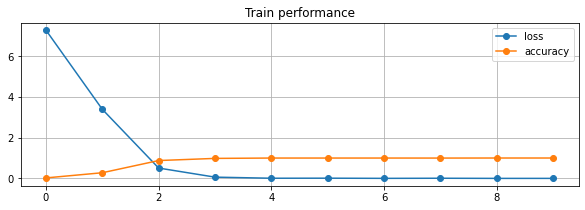

In [16]:
plt.figure(figsize=(10,3))
plt.plot(history.history["loss"], label="loss", marker="o")
plt.plot(history.history["accuracy"], label="accuracy", marker="o")
plt.grid()
plt.legend()
plt.title("Train performance")

In [34]:
preds_train = model.predict([X_train_ri, X_train_f]).argmax(axis=1)
preds_test = model.predict([X_test_ri, X_test_f]).argmax(axis=1)

print("train accuracy {}".format((preds_train == y_train).mean()))
print("test accuracy  {}".format((preds_test == y_test).mean()))

train accuracy 1.0
test accuracy  0.4882154882154882


In [10]:
def model_OD2(input_dim, extra_info_dim, num_classes):
    
    clear_session()
    inp1 = Input(shape=(input_dim[1],input_dim[2],1))
    
    conv1 = Conv2D(128, (3,3), activation="relu")(inp1)
    conv2 = Conv2D(64, (3,3), activation="relu")(conv1)
    l12 = Flatten()(conv2)

    inp2 = Input(shape=(extra_info_dim,))
    cc1 = concatenate([l12, inp2], axis=1)
    l13 =  Dense(512, activation="relu")(cc1)
    l14 =  Dense(128, activation="relu")(l13)
        
    output = Dense(num_classes, activation='softmax')(l14)

    model = Model(inputs=[inp1, inp2], outputs=output)
    model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=["accuracy"])
    model.reset_states()
    
    return model

In [ ]:
lib.multimodal_experiment(get_model=model_OD2, img_X_train=X_train_ri, fea_X_train=X_train_f, img_X_test=X_test_ri,
                          fea_X_test=X_test_f, y_train=y_train, y_test=y_test, num_classes=num_classes)

Building onehot target ... ok
Reshaping image ... ok
Training model ... 